## Exercise 1

In this exercise, you will use PCA to reduce the MINST data set and visualize the approximation.

### Step 1: Load the data

You don't actually have to do anything here!  Just run the code...

In [1]:
# @SHOW
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 2: Use PCA to reduce the data set


Visualize your result with a 2d scatter plot, colored by class (the digit identitiy)

/tmp/ipykernel_5817/2675032380.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap("tab10", 10), # 10 colors for digits 0–9


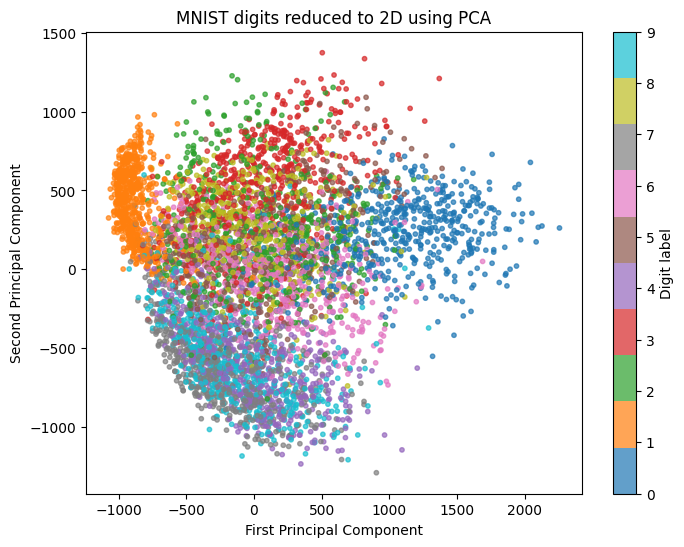

In [2]:
# Your code here


# PCA helps reduce the large number of features (784 pixels) into a smaller set
# Here we only keep 2 dimensions so we can plot them in 2D
pca_2d = PCA(n_components=2)
X_mnist_train_2d = pca_2d.fit_transform(X_mnist_train)

# Now we can visualize the digits in 2D space
plt.figure(figsize=(8,6))

# Scatter plot => each point is one digit, colored by its class (0–9)
scatter = plt.scatter(X_mnist_train_2d[:, 0],   # x-axis = first principal component
                      X_mnist_train_2d[:, 1],   # y-axis = second principal component
                      c=y_mnist_train,          # color by digit label
                      cmap=plt.cm.get_cmap("tab10", 10), # 10 colors for digits 0–9
                      s=10, alpha=0.7)          # smaller points, some transparency

plt.colorbar(scatter, ticks=range(10), label="Digit label")  # color legend
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("MNIST digits reduced to 2D using PCA")
plt.show()


#### Step 3: Scree plot

Calculate and visualize a scree plot for the first 40 component.  The y-axis should be 'percent of variance explained'.

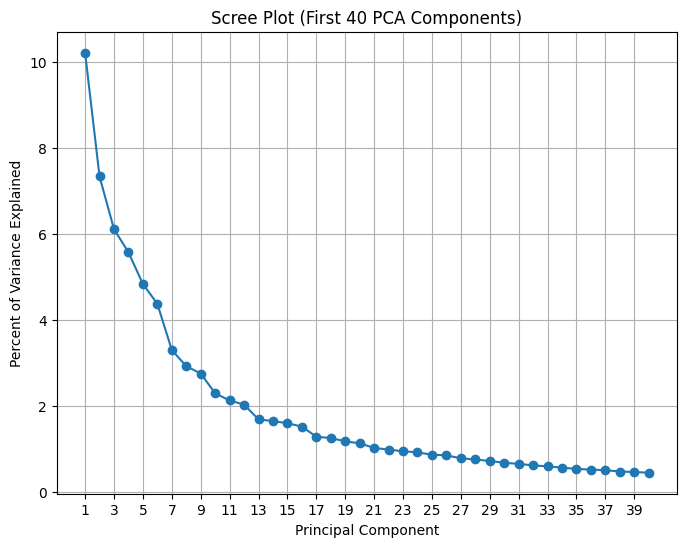

In [3]:
# Your code here
pca_40 = PCA(n_components=40)
pca_40.fit(X_mnist_train)

# Explained variance ratio tells us how much information each component keeps
explained_variance = pca_40.explained_variance_ratio_ * 100  # convert to percent

# Make the scree plot
plt.figure(figsize=(8,6))
plt.plot(range(1, 41), explained_variance, marker='o', linestyle='-')

plt.title("Scree Plot (First 40 PCA Components)")
plt.xlabel("Principal Component")
plt.ylabel("Percent of Variance Explained")
plt.xticks(range(1, 41, 2))  # show every 2nd tick for readability
plt.grid(True)
plt.show()


#### Step 4: Select the number of components


Calculate the number of components required to explain 95% of the variance

Number of components needed for 95% variance: 148


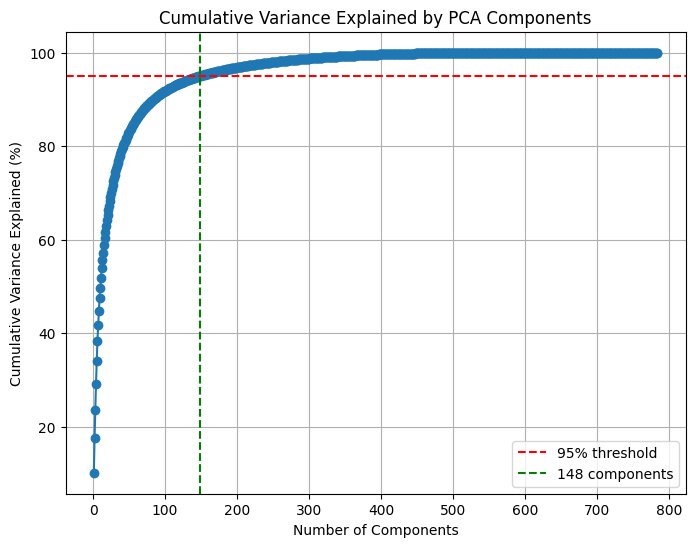

In [4]:
# Your code here
# Run PCA on full dataset while keeping all components
pca_full = PCA()
pca_full.fit(X_mnist_train)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_) * 100  

# Find the smallest number of components that reach 95% variance
n_components_95 = np.argmax(cumulative_variance >= 95) + 1  # +1 because index starts at 0
print("Number of components needed for 95% variance:", n_components_95)

# Plot cumulative variance curve for better understanding
plt.figure(figsize=(8,6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=95, color='r', linestyle='--', label="95% threshold")
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f"{n_components_95} components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained (%)")
plt.title("Cumulative Variance Explained by PCA Components")
plt.legend()
plt.grid(True)
plt.show()


### Step 5: Visualize a digit in the reduced dimensionality space


I've provided a function for visualizing a digit. Figure out how to visualize the same digit using the number of dimensions identified in Step 4.

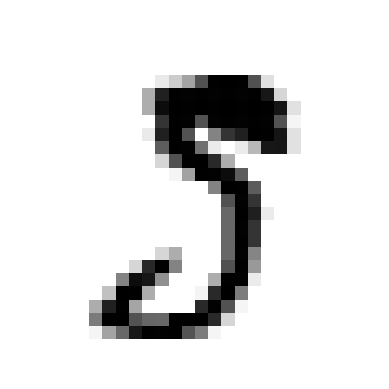

In [5]:
# @SHOW
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X_mnist_train[0])

/tmp/ipykernel_5817/1450658862.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c=y_mnist_train, cmap=plt.cm.get_cmap("tab10", 10), alpha=0.4, s=10)


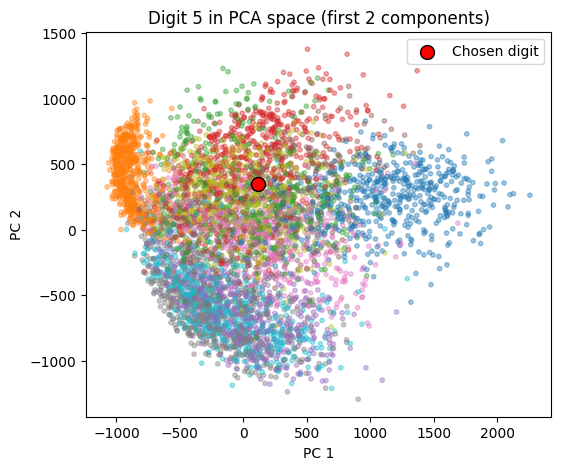

In [6]:
# Your code here
# Reduce the training data to the number of components for 95% variance
pca_reduced = PCA(n_components=n_components_95)
X_mnist_train_reduced = pca_reduced.fit_transform(X_mnist_train)

# Pick the same digit (index 0, as used before)
digit_index = 0
digit_point = X_mnist_train_reduced[digit_index]

# Since we have many dimensions, let's just plot the first two for visualization
plt.figure(figsize=(6,5))
plt.scatter(X_mnist_train_reduced[:,0], X_mnist_train_reduced[:,1], 
            c=y_mnist_train, cmap=plt.cm.get_cmap("tab10", 10), alpha=0.4, s=10)
plt.scatter(digit_point[0], digit_point[1], color="red", edgecolor="black", s=100, label="Chosen digit")

plt.title(f"Digit {y_mnist_train[digit_index]} in PCA space (first 2 components)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()


### Step 6: Use dimensionality reduction to preprocess data


See how a KNN Classifier works with and without dimensionality reduction. Preserve 80% of the variance.

In [7]:
# Your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# 1. Train KNN without PCA
knn_no_pca = KNeighborsClassifier(n_neighbors=3)

start = time.time()
knn_no_pca.fit(X_mnist_train, y_mnist_train)
y_pred_no_pca = knn_no_pca.predict(X_mnist_test)
end = time.time()

acc_no_pca = accuracy_score(y_mnist_test, y_pred_no_pca)
print("KNN without PCA - Accuracy:", acc_no_pca)
print("KNN without PCA - Time taken: {:.2f} seconds".format(end - start))


# 2. Train KNN with PCA (preserve 80% variance) 
pca_80 = PCA(0.80)   # keep enough components to explain 80% variance
X_mnist_train_pca = pca_80.fit_transform(X_mnist_train)
X_mnist_test_pca = pca_80.transform(X_mnist_test)

knn_pca = KNeighborsClassifier(n_neighbors=3)

start = time.time()
knn_pca.fit(X_mnist_train_pca, y_mnist_train)
y_pred_pca = knn_pca.predict(X_mnist_test_pca)
end = time.time()

acc_pca = accuracy_score(y_mnist_test, y_pred_pca)
print("KNN with PCA (80% variance) - Accuracy:", acc_pca)
print("KNN with PCA (80% variance) - Time taken: {:.2f} seconds".format(end - start))


KNN without PCA - Accuracy: 0.9428571428571428
KNN without PCA - Time taken: 0.41 seconds
KNN with PCA (80% variance) - Accuracy: 0.9457142857142857
KNN with PCA (80% variance) - Time taken: 0.22 seconds


## Exercise 2
<!-- @q -->
1. Try using t-SNE to visualize the MNIST data above.

In [8]:
# Your code here


2. Try using a KNN classifier to predict the data with TSNE.  How does it perform?

In [9]:
# Your code here


## Exercise 3

Try using UMAP to process the MNIST data.  Visualize the data first.

In [10]:
# @SHOW
# You might need to install UMAP.  If so, uncomment the following lines and run them

%pip install numpy==2.0
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 52.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_5817/1453820235.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c=y_mnist_train, cmap=plt.cm.get_cmap("tab10", 10),


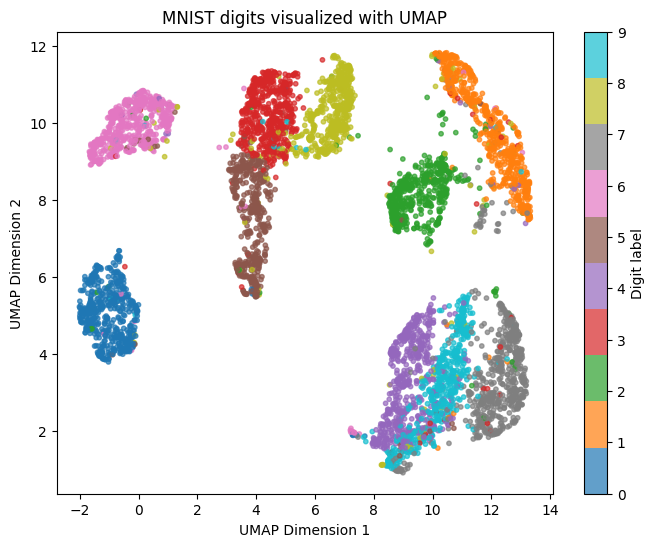

In [11]:
# Your code here
import umap.umap_ as umap
import matplotlib.pyplot as plt

# UMAP with 2 components 
umap_model = umap.UMAP(n_components=2, random_state=42)
X_mnist_train_umap = umap_model.fit_transform(X_mnist_train)

# Plot the UMAP result
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_mnist_train_umap[:,0], X_mnist_train_umap[:,1],
                      c=y_mnist_train, cmap=plt.cm.get_cmap("tab10", 10),
                      s=10, alpha=0.7)

plt.colorbar(scatter, ticks=range(10), label="Digit label")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("MNIST digits visualized with UMAP")
plt.show()


Now, calculate accuracy with KNN.

In [ ]:
# Your code here

# Step: KNN classification with UMAP-reduced features
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Reduce MNIST data to 50 dimensions using UMAP which is good for classification
umap_model = umap.UMAP(n_components=50, random_state=42)
X_mnist_train_umap = umap_model.fit_transform(X_mnist_train)
X_mnist_test_umap = umap_model.transform(X_mnist_test)

# 2. Train KNN classifier on UMAP features
knn_umap = KNeighborsClassifier(n_neighbors=3)

start = time.time()
knn_umap.fit(X_mnist_train_umap, y_mnist_train)
y_pred_umap = knn_umap.predict(X_mnist_test_umap)
end = time.time()

# 3. Evaluate accuracy
acc_umap = accuracy_score(y_mnist_test, y_pred_umap)

print("KNN with UMAP features - Accuracy:", acc_umap)
print("KNN with UMAP features - Time taken: {:.2f} seconds".format(end - start))


/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KNN with UMAP features - Accuracy: 0.9135714285714286
KNN with UMAP features - Time taken: 0.06 seconds


## Exercise 4

In the following, I've set up some sample data. Examine the relative performance of PCA and UMAP; for each, try gradually increasing the number of dimensions and examine the impact on KNN. You should also try different parameter settings for UMAP. Make sure to visualize your data after dimensionality reduction to understand what's going on!

Original Data Accuracy: 0.844


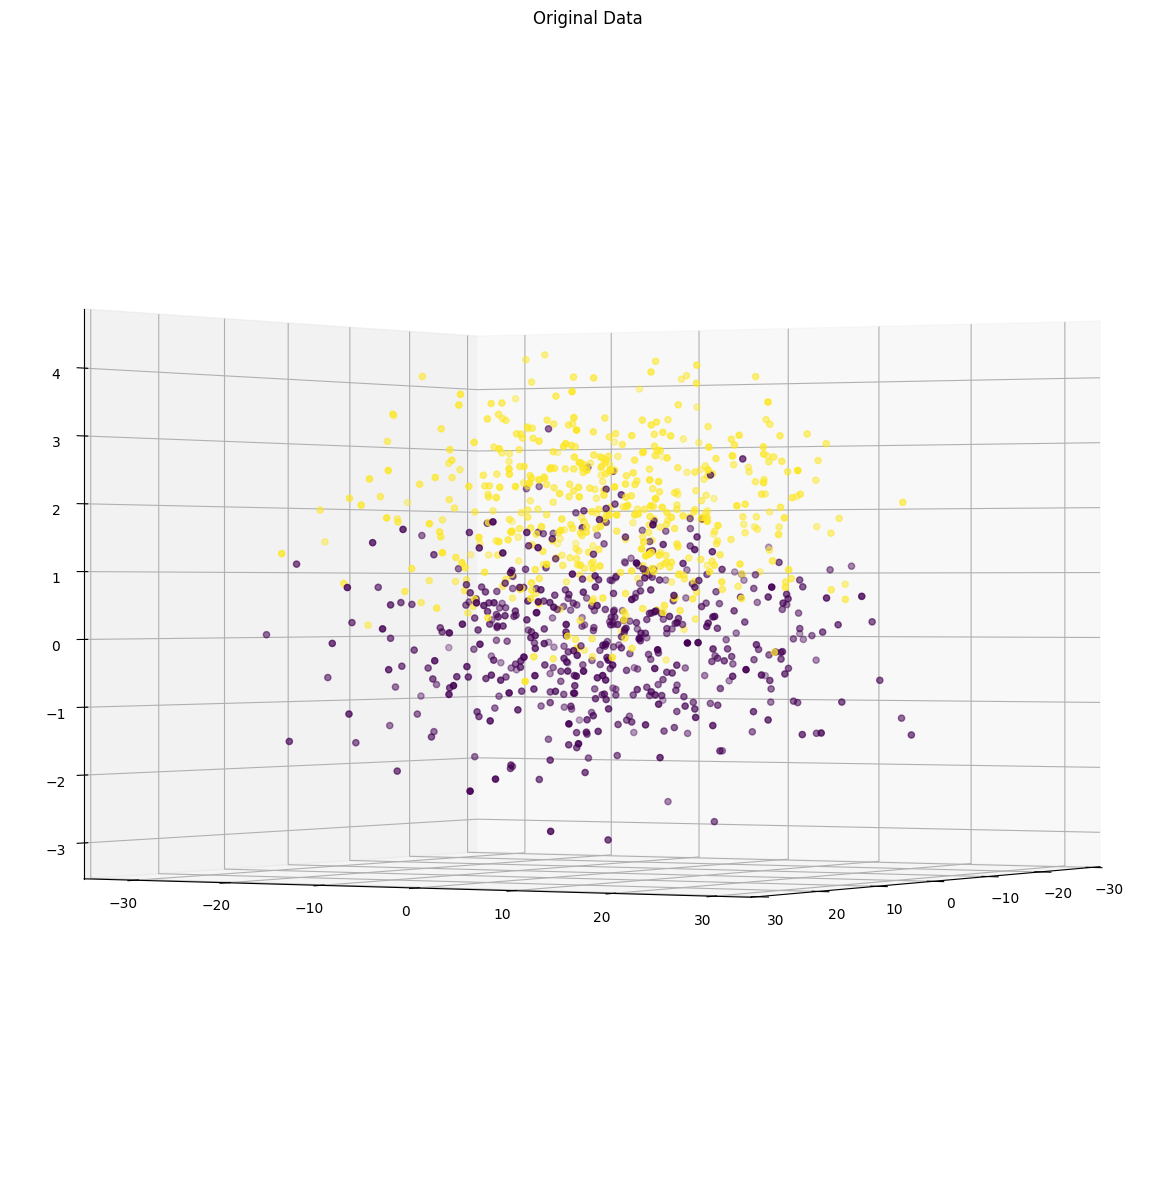

In [17]:
# @SHOW
# Generate synthetic data
np.random.seed(0)
n_points = 500

# Class 0
x0 = np.random.normal(loc=0, scale=10, size=n_points)
y0 = np.random.normal(loc=0, scale=10, size=n_points)
z0 = np.random.normal(loc=0, scale=1, size=n_points)

# Class 1
x1 = np.random.normal(loc=0, scale=10, size=n_points)
y1 = np.random.normal(loc=0, scale=10, size=n_points)
z1 = np.random.normal(loc=2, scale=1, size=n_points)

X = np.vstack((np.hstack((x0, x1)), np.hstack((y0, y1)), np.hstack((z0, z1)))).T
y = np.hstack((np.zeros(n_points), np.ones(n_points)))



# Train KNN on original data
knn = KNeighborsClassifier()
knn.fit(X, y)
y_pred = knn.predict(X)
print(f"Original Data Accuracy: {accuracy_score(y, y_pred)}")

# Create a new figure
fig = plt.figure(figsize=(15,15))

# Add 3D subplot
# The format is (rows, columns, plot_number)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=30)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_title('Original Data')

plt.show()


In [18]:
# @SHOW
# Set up train and test, and examine predictions without dimensionality reduction

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Original Data Accuracy: {accuracy_score(y_test, y_pred)}")

Original Data Accuracy: 0.725


1. Try with PCA

PCA components = 1  |  accuracy = 0.515
PCA components = 2  |  accuracy = 0.495
PCA components = 3  |  accuracy = 0.750


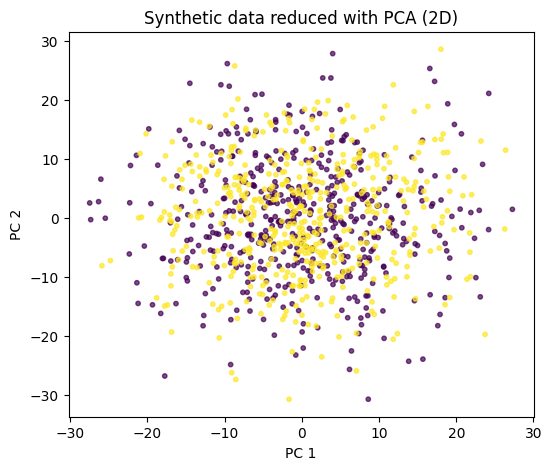

In [19]:
# Your code here
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Try 1, 2, and 3 principal components and see test accuracy
for k in [1, 2, 3]:
    pca = PCA(n_components=k, random_state=42)
    Xtr = pca.fit_transform(X_train)
    Xte = pca.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(Xtr, y_train)
    yhat = knn.predict(Xte)
    print(f"PCA components = {k}  |  accuracy = {accuracy_score(y_test, yhat):.3f}")

# Quick 2D visualization to see how PCA separates the classes
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=y, s=10, alpha=0.7, cmap="viridis")
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.title("Synthetic data reduced with PCA (2D)")
plt.show()


In [20]:
# Your code here


2. Try with UMAP.

/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP comps=2, neighbors=15, min_dist=0.1  |  accuracy = 0.560


/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP comps=2, neighbors=30, min_dist=0.1  |  accuracy = 0.555


/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP comps=3, neighbors=15, min_dist=0.1  |  accuracy = 0.600


/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


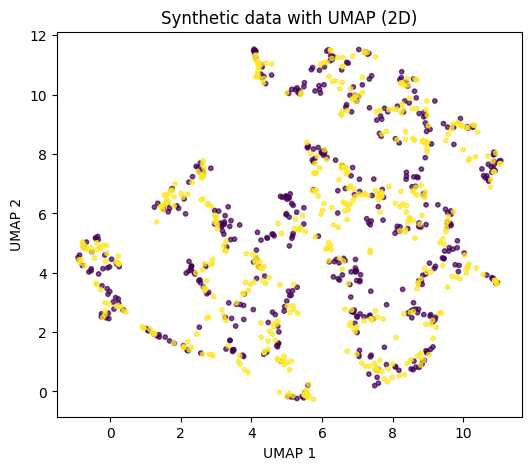

In [21]:
# Your code here
# Exercise 4: Try with UMAP, then KNN (simple and commented)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Try a few small settings to see the effect
configs = [
    {"n_components": 2, "n_neighbors": 15, "min_dist": 0.1},
    {"n_components": 2, "n_neighbors": 30, "min_dist": 0.1},
    {"n_components": 3, "n_neighbors": 15, "min_dist": 0.1},
]

for cfg in configs:
    # Reduce the train and test data with UMAP
    reducer = umap.UMAP(
        n_components=cfg["n_components"],
        n_neighbors=cfg["n_neighbors"],
        min_dist=cfg["min_dist"],
        random_state=42
    )
    Xtr = reducer.fit_transform(X_train)
    Xte = reducer.transform(X_test)

    # Train a small KNN and report accuracy
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(Xtr, y_train)
    yhat = knn.predict(Xte)
    acc = accuracy_score(y_test, yhat)

    print(
        f"UMAP comps={cfg['n_components']}, neighbors={cfg['n_neighbors']}, "
        f"min_dist={cfg['min_dist']}  |  accuracy = {acc:.3f}"
    )

# Simple 2D plot to see separation (using one of the settings above)
reducer_vis = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X2 = reducer_vis.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=y, s=10, alpha=0.7, cmap="viridis")
plt.title("Synthetic data with UMAP (2D)")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.show()


In [22]:
# Your code here


Explain your results in the cell below.  Which works better?  Why?

* We have three features, and the label really depends on z. The x and y features have big spread that behaves like noise for the label.

With PCA, the first components keep directions with the most variance. That means 1 or 2 components mostly keep x and y and drop most of the information in z, so the classes mix together and KNN accuracy stays near random. When I keep 3 components, z is included, the classes separate better, and accuracy jumps.

UMAP focuses on keeping local neighborhoods, not on variance. In only 2 dimensions it still has to compress the three dimensional structure, so z is partly lost and the classes remain mixed. UMAP can work very well on curved or complex shapes, but here the separation is basically a simple shift along z.

Conclusion: For this dataset, PCA with 3 components or the full 3D data works best because it retains the z signal that matters. UMAP in 2D does not beat that because it throws away too much of z.